<a href="https://colab.research.google.com/github/michael96247/CSE144-Applied-Machine-Learning-Homework/blob/main/CSE_144_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Assignment 4

**DUE: Sunday November 20, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Michael Chen"
STUDENT_ID = "1772059"

## Gesture Recognition
---
**BEFORE YOU START: Change the runtime to GPU. From the "Runtime" dropdown menu in the toolbar above select "change runtime type". Then change :Hardware accelerator" to GPU.**


American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabet are shown below. In this question, you will focus on classifying these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters, we want to detect which letter is being represented.


<img src = 'https://drive.google.com/uc?id=1nRxq6yqDkmumUuePXfDx_5YgGl9vKXcj' width="300">






Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1Z03YaFEvmGW5dapUex99nQF_Vxa2lriJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('asl_1000.zip')
!unzip -q asl_1000.zip

Now that you downloaded the data, you see a directory containing 26 subdirectories that contain the hand gesture images. Notice that the subdirectories are named after the classes. Each of the subdirectories contains 1000 RGB images for its' respective class. Each RGB image has a height and width of $200\times 200$. In Questions 1, 2, and 3, you will use use the tensorflow .image_dataset_from_directory() to create training and validation sets. The following cells implent a small tutorial for visualizing some training examples.

 Coding examples from adapted from: https://www.tensorflow.org/tutorials/load_data/images

### Create a dataset
Define some parameters for the loader:

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

batch_size = 32 # The batch size
img_height = 200 # Image resize height
img_width = 200 # Image resize width
data_dir = "asl_1000/asl_alphabet_train" # Data directory

Use 80% of the images for training and 20% for validation.

In [5]:
# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26000 files belonging to 26 classes.
Using 20800 files for training.


In [6]:
# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26000 files belonging to 26 classes.
Using 5200 files for validation.


Print the class names in the class_names attribute on these datasets. Notice that the class names are inferred from the subdirectory's names.




In [7]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### Visualize the data


Here are the first 9 images from the training dataset.

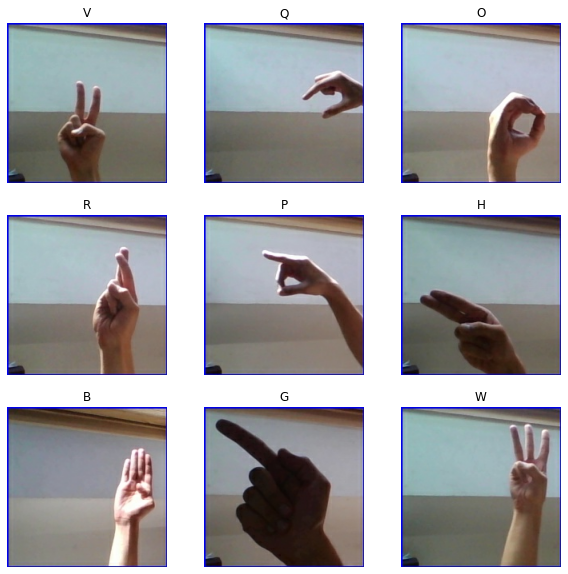

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Here are the first 9 images from the validation dataset.

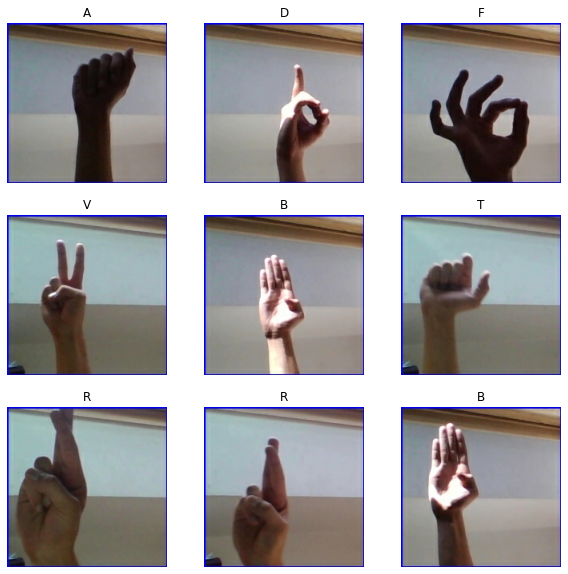

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to model.fit (shown later in this tutorial). Let's retrieve one batch from the training datset and check the outputs.

In [10]:
for features_batch, labels_batch in train_ds:
  print(features_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


features_batch is a single single batch from the training dataset. It contains $32$ $height=200$ by, $width=200$ by, $channel=3$ images from the training dataset. The size of the last dimension is 3, and contains the RGB values of the pixels. The labels are simply of size (32,). 

##  Question 1 - Fully-Connected Neural Network
---

###Part A) Understanding and Processing the Data (10 points)

Now that you downloaded the data, you should see a folder containing the images in their respective subdirectories. Complete the following steps (you may reuse the code from the tutorial):

1) read in the training and test data.

2) make sure that all of your images are of size $200\times 200$. If not, scale them appropriately.

3) rescale the pixel values of the training and test images from [0,255] to [0,1]. <br> Hint: tf.keras.layers.experimental.preprocessing.Rescaling(1./255) is recommended, see example at https://www.tensorflow.org/tutorials/load_data/images)

4) Ensure that your target values (classes) are stored appropriately. You must have 26 classes for 'A-Z'.

In [11]:
### YOUR CODE HERE ###
test_data_dir = "asl_1000/asl_alphabet_test"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels = [i for i in range(26)],
  label_mode='int'
  )

for image, label in train_ds.take(len(train_ds)):
  tf.image.resize(image, [200, 200])

for image, label in val_ds.take(len(val_ds)):
  tf.image.resize(image, [200, 200])

for image, label in test_ds.take(len(test_ds)):
  tf.image.resize(image, [200, 200])

normalization_layer = tf.keras.layers.Rescaling(1./255)

print(train_ds.class_names)
print(val_ds.class_names)

train_ds  = train_ds.map(lambda x, y: (normalization_layer(x), y))

val_ds  = val_ds.map(lambda x, y: (normalization_layer(x), y))

test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 26 files belonging to 1 classes.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


###Part B) Building a Fully-Connected Neural Network (10 points)
Now that the dataset is downloaded, let's see what happens when we try to allocate a fully-connected neural network with a flatten layer, two hidden layers and an output layer to take in the $200 \times 200 \times 3$ images. Recall that our batch size is still 32. Don't spend too much time on this model.

In [12]:
import tensorflow as tf

# Create the network

inputs = tf.keras.Input(shape=(120000)) # 200 * 200 * 3
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(inputs)
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)


# Build model
### YOUR CODE HERE ###

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Get model summary
### YOUR CODE HERE ###
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120000)]          0         
                                                                 
 dense (Dense)               (None, 100)               12000100  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 12,010,301
Trainable params: 12,010,301
Non-trainable params: 0
_________________________________________________________________


Assuming the code is correct, did you get any errors upon running the cell? If so, why do you think this error occured? Also, how many parameters does the above model have?

[YOUR ANSWER HERE] 
I did not get any error running the cell. There are 12,010,301 parameters in the model.

##  Question 2 - Convolutional Neural Networks
---
You have seen the shortcomings of using a fully-connected neural network for image recognition tasks. You will now build a convolutional network. For the rest of this assignment, we are not going to give you any starter code. You are welcome to use any code from previous class exercises, section handouts, and lectures. You may reuse your training and validation sets that you created in Question 1. You should also write your own code.

You may use the TensorFlow documentation freely. You might also find online tutorials helpful. However, all code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unnecessary for loops). Ensure enough comments are included in the code so that your TA can understand what you are doing. It is your responsibility to show that you understand what you write.

Follow the steps below to show your work.

#### Part A) Building the Network (15 points)
Build a convolutional neural network model that takes the ($200\times 200 \times 3$ RGB) image as input, and predicts the letter.

Explain your choice of the architecture: how many layers did you choose? What types of layers did you use? Did you use dropout or normalization layers? What about other decisions like activation functions, kernel size, stride, and padding? Lastly, how many parameters does your model have?

In [13]:
### YOUR CODE HERE ###
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
import tensorflow as tf

model = Sequential()

model.add(Conv2D(filters = 16,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (200, 200, 3)))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(200, activation = 'relu'))  

model.add(Dense(26, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                        

[YOUR ANSWER HERE]
There are 8 layers, which consist of 2 convolutional layers, 2 pooling layers, 1 batch normalization layer, 1 flatten layer, 1 dense layer, and 1 output layer. I use 1 batch normalization layer and did not use the dropout layer. For the activation function, I use relu because that's the activation function I am more familiar with. For the activation of the output layer, I use softmax. I make the kernel size small, with 1 stride, and with padding to give the model more information. There are 16,010,578 parameters in the model.

#### Part B) Training the Network (15 points)
Write code that trains your CNN given the training data (check the dataset tutorial to see how to use .fit with your custom dataset). Your training code should make it easy to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function and optimizer.

Plot the training curve as well.

In [14]:
### YOUR CODE HERE ###

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs = 5, 
                    batch_size = 200,
                    validation_data = val_ds,
                    verbose = 1)

Epoch 1/5
650/650 [==============================] - 17s 13ms/step - loss: 1.1175 - accuracy: 0.7443 - val_loss: 0.1342 - val_accuracy: 0.9752
Epoch 2/5
650/650 [==============================] - 8s 12ms/step - loss: 0.0557 - accuracy: 0.9837 - val_loss: 0.2549 - val_accuracy: 0.9131
Epoch 3/5
650/650 [==============================] - 8s 12ms/step - loss: 0.0441 - accuracy: 0.9856 - val_loss: 1.0329 - val_accuracy: 0.7752
Epoch 4/5
650/650 [==============================] - 8s 12ms/step - loss: 0.0255 - accuracy: 0.9931 - val_loss: 0.0136 - val_accuracy: 0.9960
Epoch 5/5
650/650 [==============================] - 8s 12ms/step - loss: 0.0311 - accuracy: 0.9905 - val_loss: 5.7290 - val_accuracy: 0.5160


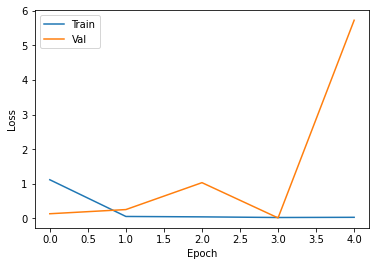

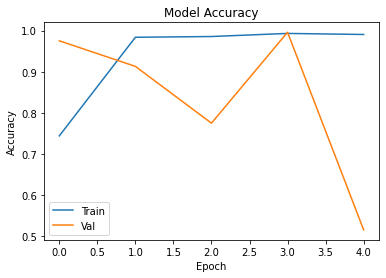

In [15]:
def plot_losses(model_info):
    plt.plot(model_info.history["loss"])
    plt.plot(model_info.history["val_loss"])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(model_info):
    plt.plot(model_info.history['accuracy'])
    plt.plot(model_info.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

# Plot your losses and accuracies
plot_losses(history)
plot_accuracies(history)

[YOUR ANSWER HERE]
I use SparseCategoricalCrossentropy as the loss function because I did not one-hot encode the labels. I use adam as the optimizer because the professor said that it is a very powerful optimizer in the previous assignment. 

#### Part C) Hyperparameter Search (15 points)

1. List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to the model architecture.

2. Tune the hyperparameters you listed previously, trying as many values as you need to until you feel satisfied that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

3. Choose the best model out of all the ones that you have trained. Justify your choice.

4. Report the test accuracy of your best model. You should only do this step once.







In [16]:
### YOUR CODE HERE ###
### 1 
model = Sequential()
model.add(Conv2D(filters = 5,      
                 kernel_size = (20, 20), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (200, 200, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(10, activation = 'relu'))  
model.add(Dense(26, activation = "softmax"))
model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history1 = model.fit(train_ds,
                    epochs = 2, 
                    batch_size = 200,
                    validation_data = test_ds,
                    verbose = 1)

### 2

model = Sequential()
model.add(Conv2D(filters = 5,      
                 kernel_size = (50, 50), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (200, 200, 3)))
model.add(MaxPooling2D(pool_size = (10, 10)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(5, activation = 'relu'))  
model.add(Dense(26, activation = "softmax"))
model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history2 = model.fit(train_ds,
                    epochs = 3, 
                    batch_size = 200,
                    validation_data = test_ds,
                    verbose = 1)

### 3

model = Sequential()

model.add(Conv2D(filters = 8,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (200, 200, 3)))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(100, activation = 'relu'))   

model.add(Dense(26, activation = "softmax"))

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history3 = model.fit(train_ds,
                    epochs = 3, 
                    batch_size = 200,
                    validation_data = test_ds,
                    verbose = 1)

### 4

model = Sequential()

model.add(Conv2D(filters = 16,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (200, 200, 3)))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(300, activation = 'relu')) 

model.add(Dropout(0.2))

model.add(Dense(26, activation = "softmax"))

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history4 = model.fit(train_ds,
                    epochs = 5, 
                    batch_size = 200,
                    validation_data = test_ds,
                    verbose = 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 200, 200, 5)       6005      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 5)      0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 5)      20        
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 50000)             0         
                                                                 
 dense_5 (Dense)             (None, 10)                500010    
                                                                 
 dense_6 (Dense)             (None, 26)               

650/650 [==============================] - 8s 11ms/step - loss: 1.2142 - accuracy: 0.6735 - val_loss: 1.1869 - val_accuracy: 0.8462
Epoch 2/5
650/650 [==============================] - 7s 11ms/step - loss: 0.2292 - accuracy: 0.9190 - val_loss: 2.6696 - val_accuracy: 0.5769
Epoch 3/5
650/650 [==============================] - 7s 11ms/step - loss: 0.1344 - accuracy: 0.9518 - val_loss: 1.6756 - val_accuracy: 0.9231
Epoch 4/5
650/650 [==============================] - 7s 11ms/step - loss: 0.1005 - accuracy: 0.9646 - val_loss: 1.5476 - val_accuracy: 0.9615
Epoch 5/5
650/650 [==============================] - 7s 11ms/step - loss: 0.0791 - accuracy: 0.9727 - val_loss: 3.5831 - val_accuracy: 0.6538


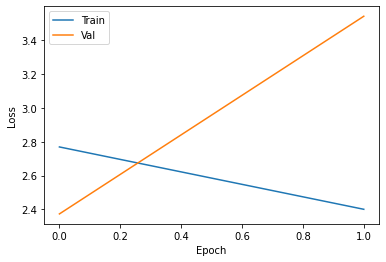

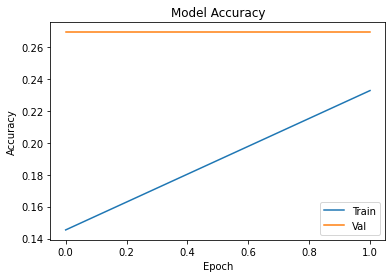

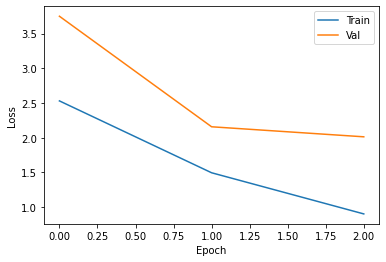

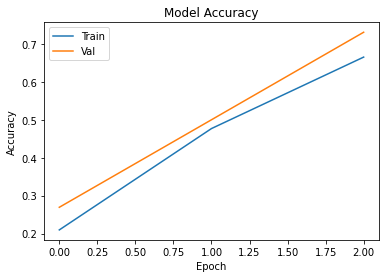

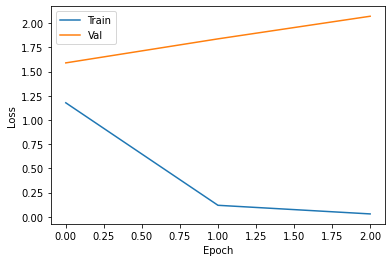

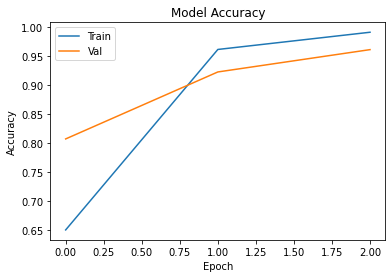

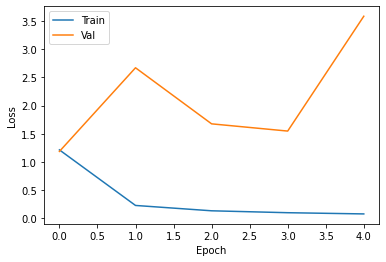

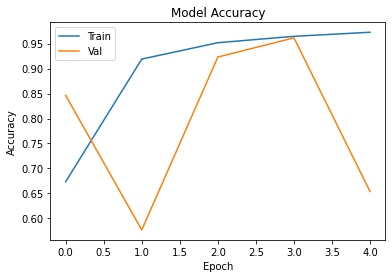

In [17]:
def plot_losses(model_info):
    plt.plot(model_info.history["loss"])
    plt.plot(model_info.history["val_loss"])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(model_info):
    plt.plot(model_info.history['accuracy'])
    plt.plot(model_info.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

plot_losses(history1)
plot_accuracies(history1)
plot_losses(history2)
plot_accuracies(history2)
plot_losses(history3)
plot_accuracies(history3)
plot_losses(history4)
plot_accuracies(history4)

[YOUR ANSWER HERE]
1. The 3 hyperparameters I think are: the number of neurons at the dense layer after the flatten layer, the number of filters in the convolutional layers, and the kernel size of the convolutional layer
2. Plots are above
3. The number of filters in the convolutional layers really affects the result of the training a lot. The first two graphs show the models with only one convolutional layer (which has only 5 filters). Both of them also have large kernel sizes ( (20, 20) and (50, 50) ) in the convolutional layer. And both of them have few neurons at the dense layer after the flatten layer. The result is that both of the models have poor accuracy on the test data. The third model have two convolutional layers, and each of the convolutional layers has more filters (8 and 16 this time) and a much smaller kernel size (3, 3). The dense layer after the flatten layer also contains more neurons (100 neurons). The result is pretty good with 0.8827 accuracy on the test data, which is far better than the previous two models. The last model is the improved version of the third model, which has even more filters in the two convolution layers (from 8 to 16, 16 to 32), and the kernel size is the same (3, 3). The neurons at the dense layer after the flatten layer also increase from 100 to 300. I also added dropout of 0.2 to prevent overfitting. The result is the best among all the models, with an accuracy of 0.9615 on the test data, which is very high.
4. The best result I get is from the last model, which has 0.9615 accuracies for the test data. 

## Question 3 - Transfer Learning
---
For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a similar task to the one you need to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed Transfer Learning. In this assignment, we will use Transfer Learning to extract features from the hand gesture images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which get utilized by the fully-connected layers for correct classification.


Keras even has pretrained models built in for this purpose. 

#### Keras Pretrained Models
        Xception
        VGG16
        VGG19
        ResNet, ResNetV2, ResNeXt
        InceptionV3
        InceptionResNetV2
        MobileNet
        MobileNetV2
        DenseNet
        NASNet

Usually one uses the layers of the pretrained model up to some point, and then creates some fully connected layers to learn the desired recognition task. The earlier layers are "frozen", and only the later layers need to be trained. We'll use VGG16, which was trained to recognize 1000 objects in ImageNet. What we're doing here for our classifier may be akin to killing a fly with a shotgun, but the same process can be used to recognize objects the original network couldn't (i.e., you could use this technique to train your computer to recognize family and friends).

In [18]:
# Some stuff we'll need...
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

Creating this pretrained network is a one line command. Notice we specified that the "top" should not be included. We aren't classifying 1000 different categories like ImageNet, so we don't include that layer. We'll add our own layer more suited to the task at hand.

In [19]:
# Import the VGG16 trained neural network model, minus it's last (top) neuron layer.
base_model = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (200, 200, 3), 
                   pooling = None)

58889256/58889256 [==============================] - 0s 0us/step


Let's take a look at this pretrained model:

In [20]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

Please do realize, this may be overkill for our toy recognition task. One could use this network with some layers (as we're about to add) to recognize 100 dog breeds or to recognize all your friends. If you wanted to recognize 100 dog breeds, you would use a final 100 neuron softmax for the final layer. We'll need a final softmax layer as before. First let's freeze all these pretrained weights. They are fine as they are.

In [21]:
# This freezes the weights of our VGG16 pretrained model.
for layer in base_model.layers:  
    print(layer)
    layer.trainable = False

### Part A) Building the Classifier (10 points)
Now let's just add a flatten layer, a trainable dense layer, and a final softmax layer to the network to complete the classifier model for our gesture recognition task. Use Keras' functional approach to building a network.

In [22]:
# Now add layers to our pre-trained base model and add classification layers on top of it
x = base_model.output  ### YOUR CODE HERE ### 
x = Flatten()(x)
x = Dense(units=60,activation='relu')(x)
x = Dense(units=26,activation='softmax')(x)

# And now put this all together to create our new model.
model = Model(inputs = base_model.input, outputs = x) 
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

### Part B) Initializing Training Parameters (5 points)

Compile the model using an appropriate loss function and optimizer.

In [23]:
# Compile the model
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop 
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
### YOUR CODE HERE ###

### Part C) Training the Model (10 points)

Train your new network, including any hyperparameter tuning. Plot the training curve of your best model only.

As you can see here in the Keras docs:

https://keras.io/api/applications/vgg/#vgg16-function

that we are required to preprocess our image data in a specific way to use this pretrained model, so let's go ahead and do that first.

In [24]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26000 files belonging to 26 classes.
Using 20800 files for training.
Found 26000 files belonging to 26 classes.
Using 5200 files for validation.


In [25]:
# Preprocess your input image data

# for image, label in train_ds.take(len(train_ds)):
#   X.append((image))
#   y.append(label)
# X = np.array(X)
# X = preprocess_input(X)

train_ds_preprocess = train_ds.map(lambda x, y:(preprocess_input(x), y))
val_ds_preprocess = val_ds.map(lambda x, y:(preprocess_input(x), y))

### YOUR CODE HERE ###

In [26]:
# Train the model

### YOUR CODE HERE ###

model_info = model.fit(train_ds_preprocess ,batch_size=100, epochs=2, validation_data = val_ds_preprocess)

Epoch 1/2
650/650 [==============================] - 20s 28ms/step - loss: 0.4268 - accuracy: 0.9111 - val_loss: 0.0063 - val_accuracy: 0.9985
Epoch 2/2
650/650 [==============================] - 18s 28ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 2.1233e-04 - val_accuracy: 1.0000


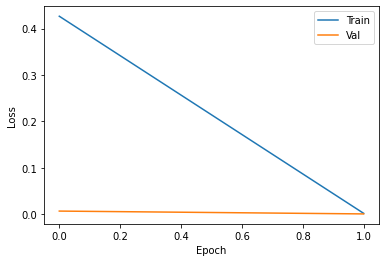

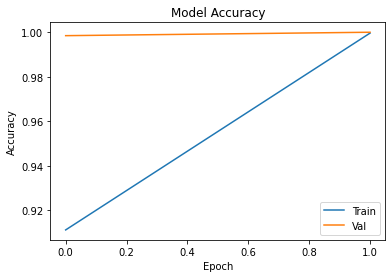

In [27]:
def plot_losses(model_info):
    plt.plot(model_info.history["loss"])
    plt.plot(model_info.history["val_loss"])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(hist):
    plt.plot(model_info.history['accuracy'])
    plt.plot(model_info.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

plot_losses(model_info)
plot_accuracies(model_info)
### YOUR CODE HERE ###

### Part D) Your Best Classifier (10 points)

Add on your own last layers to the pretrained model and train it on the training data (in the previous parts you could have only one flatten layer and one dense layer to do the classification). You can increase (or decrease) the number of nodes per layer, increase (or decrease) the number of layers, and add dropout if your model is overfitting, change the hyperparameters, change your optimizer, etc. Try to get the validation accuracy higher than what the previous transfer learning model was able to obtain, and try to minimize the amount of overfitting.

Plot the classification accuracy for each epoch. Report the best test accuracy your model was able to achieve.

In [28]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels = [i for i in range(26)]
  )

test_ds_preprocess = test_ds.map(lambda x, y:(preprocess_input(x), y))

Found 26 files belonging to 1 classes.


In [29]:
### YOUR CODE HERE ###

x = base_model.output  ### YOUR CODE HERE ### 
x = Flatten()(x)
x = Dense(units=100,activation='relu')(x)
x = Dense(units=26,activation='softmax')(x)

# And now put this all together to create our new model.
model = Model(inputs = base_model.input, outputs = x) 
model.summary()

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

model_info = model.fit(train_ds_preprocess ,batch_size=100, epochs=5, validation_data = test_ds_preprocess)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

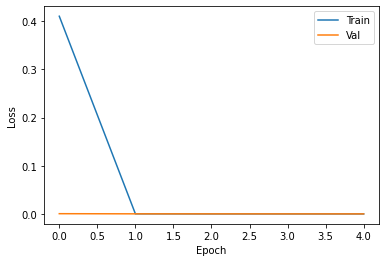

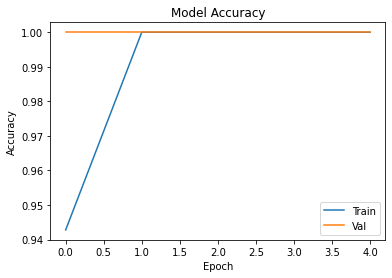

In [30]:
def plot_losses(model_info):
    plt.plot(model_info.history["loss"])
    plt.plot(model_info.history["val_loss"])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(model_info):
    plt.plot(model_info.history['accuracy'])
    plt.plot(model_info.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

# Plot your losses and accuracies
plot_losses(model_info)
plot_accuracies(model_info)

[YOUR ANSWER HERE]

I increase the number of nodes in the dense layer from 60 to 100 and also increase the epoch from 2 to 5. Now I have a test accuracy of 1.0, which is higher than the previous transfer learning model.